In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Load the Data

In [3]:
# Load the data and inspect them
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


Successfully Read!
<br>Date: the date of each record
<br>Open: first traded price on each trading day
<br>High: highest price on each trading day
<br>Low: lowest price on each trading day
<br>Close: last price on each trading day
<br>Adj close: adjusted close price
<br>Volume: the number of stocks traded on each trading day

What should we do next?
We need to learn the regulations of the data to do prediction. Based on observation and business knowledge, we could find that if we would like to do prediction, we could predict the closing prices. Then, the time series conditions of the closing price will be shown in the plot below.

<ipython-input-4-de25d7cac74b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Date = pd.to_datetime(data.Date, format = '%Y/%m/%d')


<Axes: xlabel='Date'>

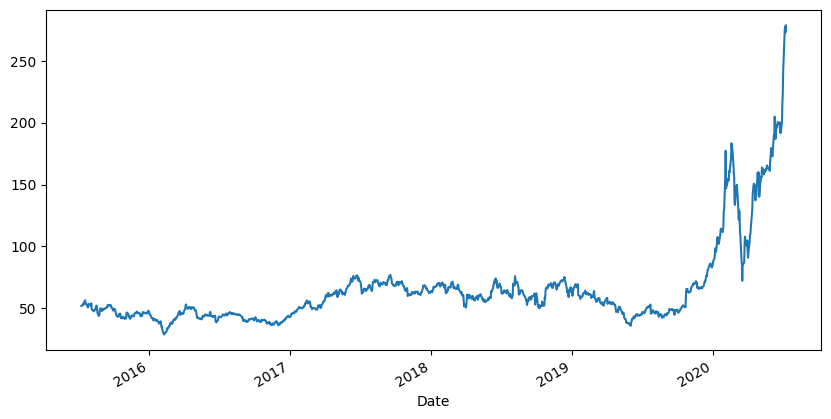

In [4]:
#visualization the stock price without lag
data= data[['Date', 'Close']]
data.Date = pd.to_datetime(data.Date, format = '%Y/%m/%d')
plot = data.set_index('Date')

plot['Close'].plot(figsize=(10,5))

In [5]:
#we will continue working with the closing price(delete the date)
data_drop=data.drop(["Date"],axis=1)
data_new=data_drop.values

In [6]:
print(data_new)

[[ 51.830002]
 [ 52.431999]
 [ 53.130001]
 ...
 [277.971985]
 [273.175995]
 [278.855988]]


In [7]:
data_new.shape

(1259, 1)

In [8]:
#normalized the data
scaler = MinMaxScaler(feature_range = (0, 1))
data_normalized = scaler.fit_transform(data_new)

# Split the data

In [9]:
#split the data into training and test sets
#set that training data is about 80%, test is about 20% (as normal setting)
training_size = int(len(data_normalized) * 0.8)
test_size= len(data_normalized)-training_size

train = data_normalized[0:training_size, :]
test = data_normalized[training_size:len(data_normalized), :]

In [10]:
print(training_size)
print(test_size)
train.shape, test.shape

1007
252


((1007, 1), (252, 1))

#One-day time lag

In [11]:
#build the input features with different time lags
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i + lag), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [12]:
lag=1

In [13]:
#The closing price of the last day could predict the price of today;
#the price of today could predict the price of tomorrow.
X_train, Y_train = input_features(train, lag)
X_test, Y_test = input_features(test, lag)

#Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((1006, 1, 1), (251, 1, 1), (1006,), (251,))

In [14]:
#create the LSTM model
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm(lstm_layer)

In [15]:
#change another drop rate
def lstm2(lstm_layer=4):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm2(lstm_layer)

In [ ]:
models={'drop_0.2_4_h_layer': lstm(4),'drop_0.2_5_h_layer': lstm(5), 'drop_0.2_6_h_layer': lstm(6),
        'drop_0.3_4_h_layer': lstm2(4),'drop_0.3_5_h_layer': lstm2(5), 'drop_0.3_6_h_layer': lstm2(6)}

In [17]:
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

history = model.fit(X_train, Y_train, epochs = 30, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

Epoch 1/30
51/51 [==============================] - 11s 23ms/step - loss: 0.0027 - mean_absolute_error: 0.0420 - val_loss: 0.0650 - val_mean_absolute_error: 0.1858
Epoch 2/30
51/51 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0485 - val_loss: 0.0678 - val_mean_absolute_error: 0.1891
Epoch 3/30
51/51 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0477 - val_loss: 0.0660 - val_mean_absolute_error: 0.1867
Epoch 4/30
51/51 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0466 - val_loss: 0.0635 - val_mean_absolute_error: 0.1832
Epoch 5/30
51/51 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0459 - val_loss: 0.0606 - val_mean_absolute_error: 0.1790
Epoch 6/30
51/51 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_absolute_error: 0.0451 - val_loss: 0.0564 - val_mean_absolute_error: 0.1728
Epoch 7/30
51/51 [========

In [ ]:
histories={}

for name, model in models.items():
  model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

  history = model.fit(X_train, Y_train, epochs = 30, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

  histories[name]=history

Epoch 1/100
51/51 [==============================] - 6s 23ms/step - loss: 0.0026 - mean_absolute_error: 0.0416 - val_loss: 0.0688 - val_mean_absolute_error: 0.1912
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0506 - val_loss: 0.0728 - val_mean_absolute_error: 0.1962
Epoch 3/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0031 - mean_absolute_error: 0.0488 - val_loss: 0.0711 - val_mean_absolute_error: 0.1938
Epoch 4/100
51/51 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0482 - val_loss: 0.0704 - val_mean_absolute_error: 0.1928
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_absolute_error: 0.0474 - val_loss: 0.0675 - val_mean_absolute_error: 0.1888
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0463 - val_loss: 0.0645 - val_mean_absolute_error: 0.1846
Epoch 7/100
51/51 [==

In [ ]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y, color="blue")

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y, color="yellow")

    plt.ylabel('Losses')
    plt.xlabel('Epoches')
    plt.legend(['training loss','validation loss'])
    plt.ylim(ymax=0.10,ymin=0)
    plt.xlim(xmax=100,xmin=0)
    plt.grid(True)
    plt.show()

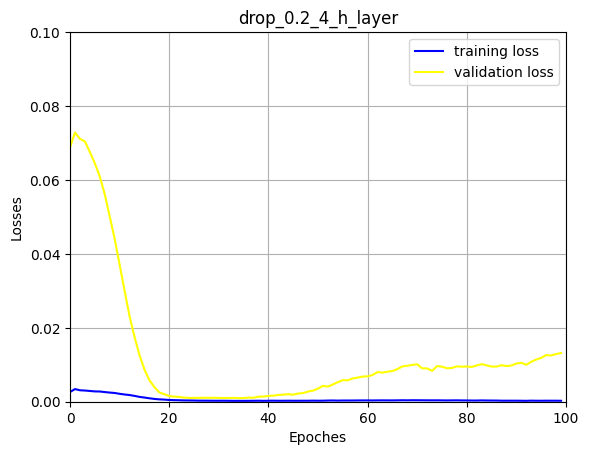

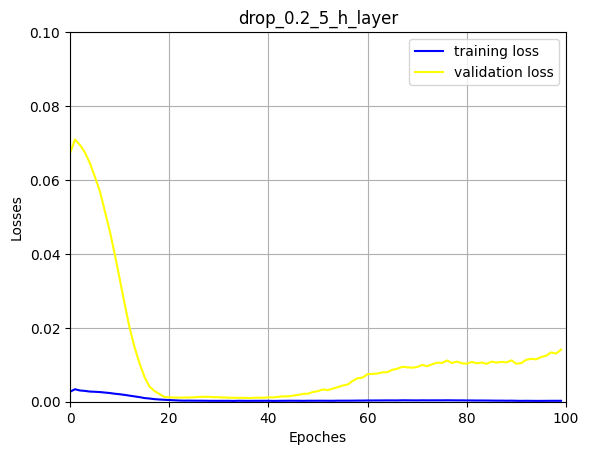

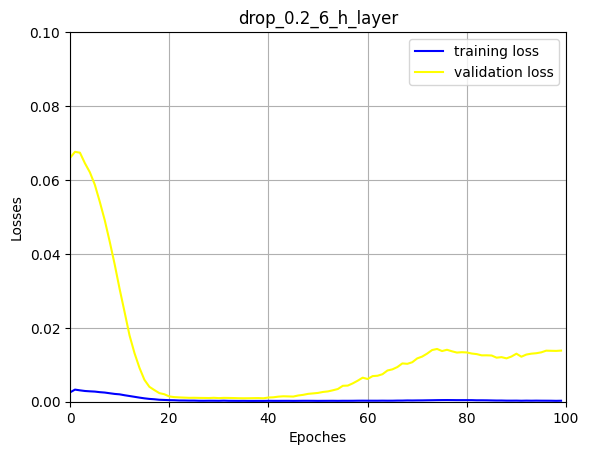

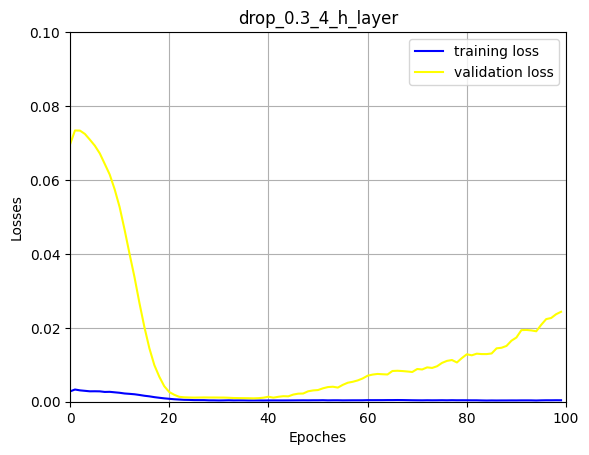

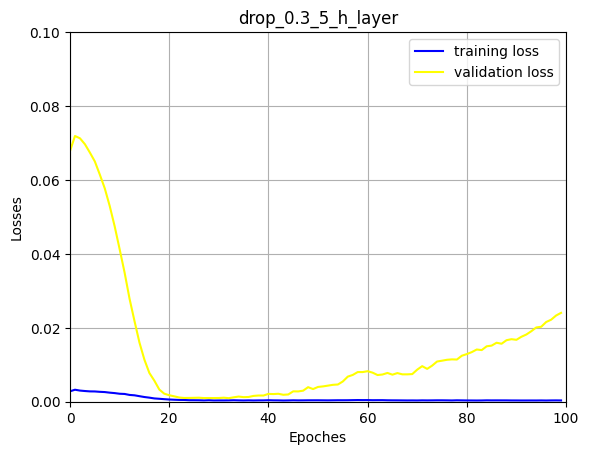

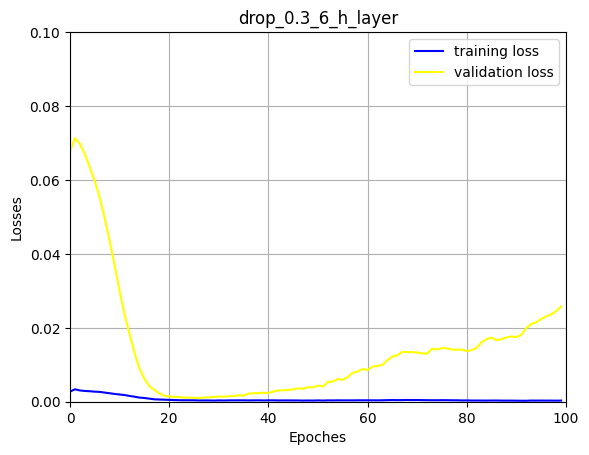

In [ ]:
for name, history in histories.items():
  plt.title(name)
  plot_loss(history.history['loss'],history.history['val_loss'], "Loss")




In [18]:
#prediction
Y_prediction = model.predict(X_test)
Y_prediction = scaler.inverse_transform(Y_prediction)

8/8 [==============================] - 1s 3ms/step


In [19]:
Y_prediction.shape

(251, 1)

In [20]:
train_df = data.iloc[:training_size , :]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
test_df = data.iloc[training_size: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


<ipython-input-20-4ef475970526>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
<ipython-input-20-4ef475970526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


In [21]:
test_df.shape

(252, 2)

In [22]:
test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values

test_df.iloc[lag:, 2] = Y_prediction

<ipython-input-22-e78d812fd9ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values


In [23]:
test_df.head()

,Date,Close,Prediction
1007,2019-07-11,47.720001,NaN
1008,2019-07-12,49.015999,48.673698
1009,2019-07-15,50.700001,49.706097
1010,2019-07-16,50.476002,51.054607
1011,2019-07-17,50.972000,50.874779


<Axes: xlabel='Date'>

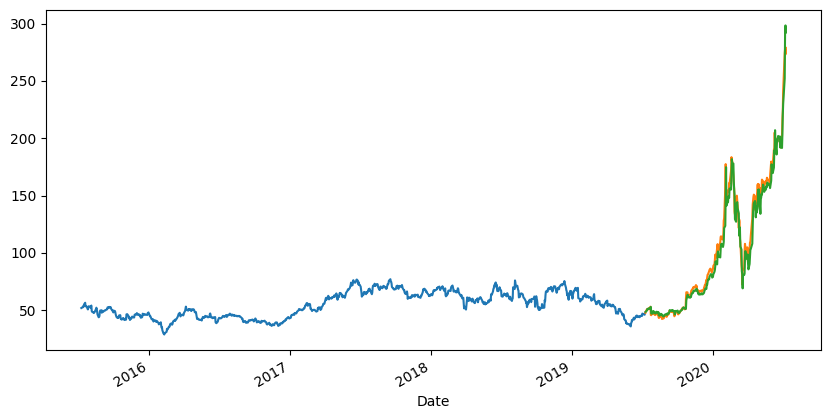

In [24]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')


plot['Close'].plot(figsize=(10,5))
plot2['Close'].plot(figsize=(10,5))
plot2['Prediction'].plot(figsize=(10,5))

#Five-day time lag

In [50]:
#build the input features with different time lags
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i + lag), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [51]:
lag=5

In [52]:
#The closing price of the last day could predict the price of today;
#the price of today could predict the price of tomorrow.
X_train, Y_train = input_features(train, lag)
X_test, Y_test = input_features(test, lag)

#Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((1002, 1, 5), (247, 1, 5), (1002,), (247,))

In [53]:
#create the LSTM model
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm(lstm_layer)

In [ ]:
#change another drop rate
def lstm2(lstm_layer=4):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm2(lstm_layer)

In [ ]:
models={'drop_0.2_4_h_layer': lstm(4),'drop_0.2_5_h_layer': lstm(5), 'drop_0.2_6_h_layer': lstm(6),
        'drop_0.3_4_h_layer': lstm2(4),'drop_0.3_5_h_layer': lstm2(5), 'drop_0.3_6_h_layer': lstm2(6)}

In [61]:
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

history = model.fit(X_train, Y_train, epochs = 20, batch_size = 20,
                      validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

Epoch 1/20
51/51 [==============================] - 8s 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0421 - val_loss: 0.0542 - val_mean_absolute_error: 0.1700
Epoch 2/20
51/51 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0457 - val_loss: 0.0500 - val_mean_absolute_error: 0.1632
Epoch 3/20
51/51 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0435 - val_loss: 0.0400 - val_mean_absolute_error: 0.1463
Epoch 4/20
51/51 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0391 - val_loss: 0.0271 - val_mean_absolute_error: 0.1213
Epoch 5/20
51/51 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0360 - val_loss: 0.0172 - val_mean_absolute_error: 0.0975
Epoch 6/20
51/51 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0314 - val_loss: 0.0084 - val_mean_absolute_error: 0.0693
Epoch 7/20
51/51 [=========

In [ ]:
histories={}

for name, model in models.items():
  model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

  history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20,
                      validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

  histories[name]=history

Epoch 1/100
51/51 [==============================] - 3s 11ms/step - loss: 0.0024 - mean_absolute_error: 0.0399 - val_loss: 0.0593 - val_mean_absolute_error: 0.1775
Epoch 2/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0448 - val_loss: 0.0548 - val_mean_absolute_error: 0.1707
Epoch 3/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0458 - val_loss: 0.0487 - val_mean_absolute_error: 0.1608
Epoch 4/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0025 - mean_absolute_error: 0.0427 - val_loss: 0.0386 - val_mean_absolute_error: 0.1435
Epoch 5/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0388 - val_loss: 0.0278 - val_mean_absolute_error: 0.1222
Epoch 6/100
51/51 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0350 - val_loss: 0.0161 - val_mean_absolute_error: 0.0941
Epoch 7/100
51/51 [==

In [ ]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y, color="blue")

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y, color="yellow")

    plt.ylabel('Losses')
    plt.xlabel('Epoches')
    plt.legend(['training loss','validation loss'])
    plt.ylim(ymax=0.10,ymin=0)
    plt.xlim(xmax=100,xmin=0)
    plt.grid(True)
    plt.show()

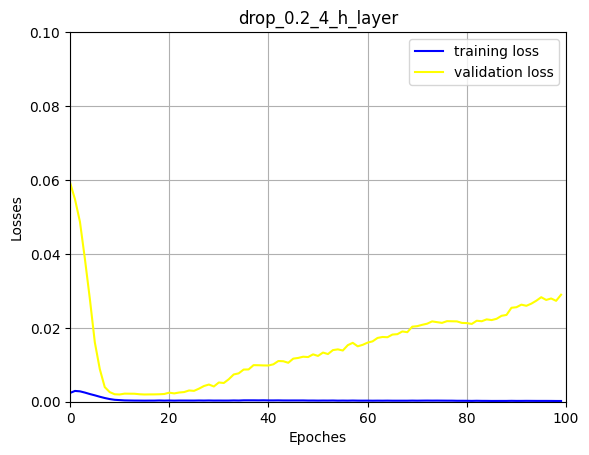

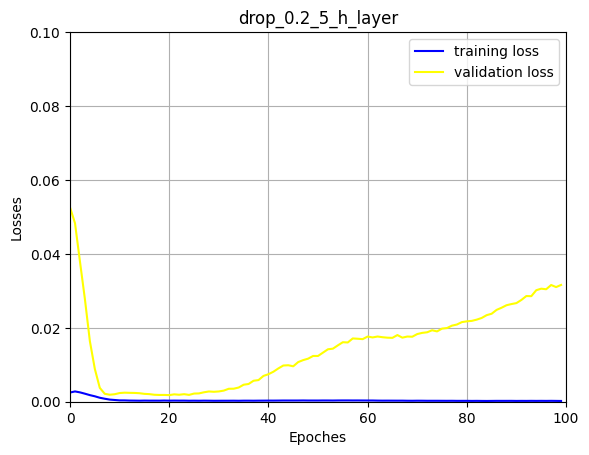

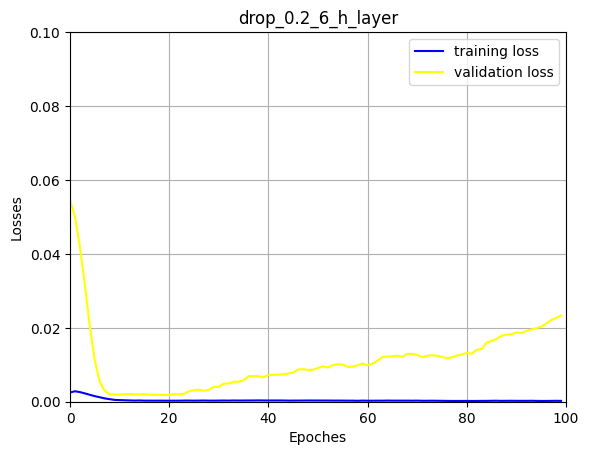

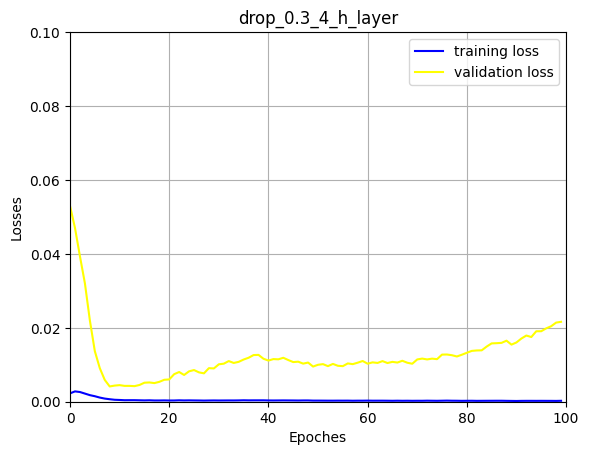

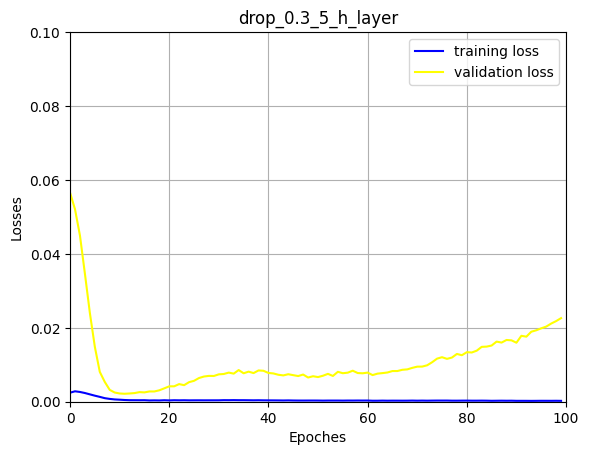

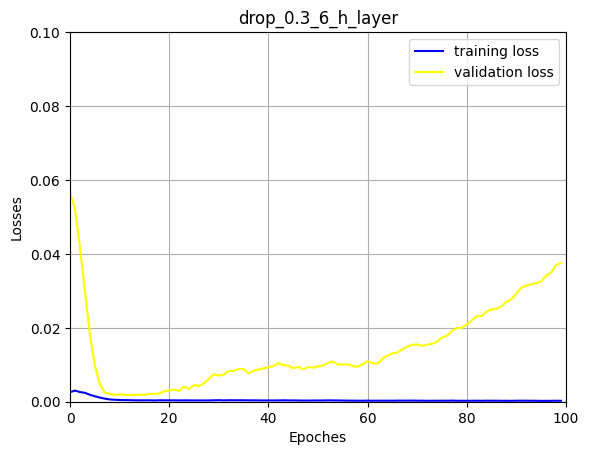

In [ ]:
for name, history in histories.items():
  plt.title(name)
  plot_loss(history.history['loss'],history.history['val_loss'], "Loss")

In [62]:
#prediction
Y_prediction = model.predict(X_test)
Y_prediction = scaler.inverse_transform(Y_prediction)

8/8 [==============================] - 1s 4ms/step


In [63]:
Y_prediction.shape

(247, 1)

In [64]:
train_df = data.iloc[:training_size , :]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
test_df = data.iloc[training_size: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


<ipython-input-64-4ef475970526>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
<ipython-input-64-4ef475970526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


In [57]:
test_df.shape

(252, 2)

In [65]:
test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values

test_df.iloc[lag:, 2] = Y_prediction

<ipython-input-65-e78d812fd9ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values


In [66]:
test_df.head(7)

,Date,Close,Prediction
1007,2019-07-11,47.720001,NaN
1008,2019-07-12,49.015999,NaN
1009,2019-07-15,50.700001,NaN
1010,2019-07-16,50.476002,NaN
1011,2019-07-17,50.972000,NaN
1012,2019-07-18,50.708000,50.001373
1013,2019-07-19,51.636002,50.438107


<Axes: xlabel='Date'>

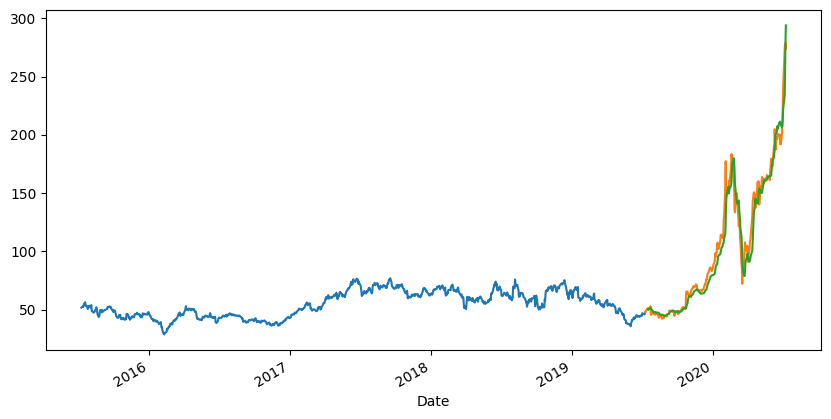

In [67]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')


plot['Close'].plot(figsize=(10,5))
plot2['Close'].plot(figsize=(10,5))
plot2['Prediction'].plot(figsize=(10,5))

# Ten-day time lag

In [38]:
#build the input features with different time lags
def input_features(data, lag):
    X, Y = [], []
    for i in range(len(data) -lag):
        X.append(data[i:(i + lag), 0])
        Y.append(data[i + lag, 0])
    return np.array(X), np.array(Y)

In [39]:
lag=10

In [40]:
#The closing price of the last day could predict the price of today;
#the price of today could predict the price of tomorrow.
X_train, Y_train = input_features(train, lag)
X_test, Y_test = input_features(test, lag)

#Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape,X_test.shape, Y_train.shape, Y_test.shape

((997, 1, 10), (242, 1, 10), (997,), (242,))

In [41]:
#create the LSTM model
def lstm(lstm_layer=6):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm(lstm_layer)

In [ ]:
#change another drop rate
def lstm2(lstm_layer=4):
  model = Sequential()

  model.add(LSTM(units = 50, activation = 'relu', return_sequences=True,
                 input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  for layer in range(lstm_layer-1):
    model.add(LSTM(50, return_sequences= False))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

for lstm_layer in [4,5,6]:
  model=lstm2(lstm_layer)

In [ ]:
models={'drop_0.2_4_h_layer': lstm(4),'drop_0.2_5_h_layer': lstm(5), 'drop_0.2_6_h_layer': lstm(6),
        'drop_0.3_4_h_layer': lstm2(4),'drop_0.3_5_h_layer': lstm2(5), 'drop_0.3_6_h_layer': lstm2(6)}

In [42]:
model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

history = model.fit(X_train, Y_train, epochs = 15, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

Epoch 1/15
50/50 [==============================] - 12s 34ms/step - loss: 0.0019 - mean_absolute_error: 0.0355 - val_loss: 0.0429 - val_mean_absolute_error: 0.1511
Epoch 2/15
50/50 [==============================] - 1s 10ms/step - loss: 0.0022 - mean_absolute_error: 0.0379 - val_loss: 0.0324 - val_mean_absolute_error: 0.1317
Epoch 3/15
50/50 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0386 - val_loss: 0.0230 - val_mean_absolute_error: 0.1115
Epoch 4/15
50/50 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_absolute_error: 0.0344 - val_loss: 0.0150 - val_mean_absolute_error: 0.0903
Epoch 5/15
50/50 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0309 - val_loss: 0.0093 - val_mean_absolute_error: 0.0718
Epoch 6/15
50/50 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0264 - val_loss: 0.0066 - val_mean_absolute_error: 0.0598
Epoch 7/15
50/50 [=======

In [ ]:
histories={}

for name, model in models.items():
  model.compile(optimizer = 'adam', loss = 'mse' , metrics="mean_absolute_error")

  history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), verbose = 1, shuffle = False)

  histories[name]=history

Epoch 1/100
50/50 [==============================] - 3s 11ms/step - loss: 0.0021 - mean_absolute_error: 0.0382 - val_loss: 0.0488 - val_mean_absolute_error: 0.1615
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0418 - val_loss: 0.0384 - val_mean_absolute_error: 0.1436
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0413 - val_loss: 0.0274 - val_mean_absolute_error: 0.1221
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - mean_absolute_error: 0.0379 - val_loss: 0.0183 - val_mean_absolute_error: 0.1001
Epoch 5/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_absolute_error: 0.0327 - val_loss: 0.0105 - val_mean_absolute_error: 0.0766
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0288 - val_loss: 0.0056 - val_mean_absolute_error: 0.0554
Epoch 7/100
50/50 [==

In [ ]:
def plot_loss(train_loss, val_loss, Title):
    x = [i for i in range(0, len(val_loss))]
    y= train_loss
    plt.plot(x,y, color="blue")

    x = [i for i in range(0, len(val_loss))]
    y= val_loss
    plt.plot(x,y, color="yellow")

    plt.ylabel('Losses')
    plt.xlabel('Epoches')
    plt.legend(['training loss','validation loss'])
    plt.ylim(ymax=0.10,ymin=0)
    plt.xlim(xmax=100,xmin=0)
    plt.grid(True)
    plt.show()

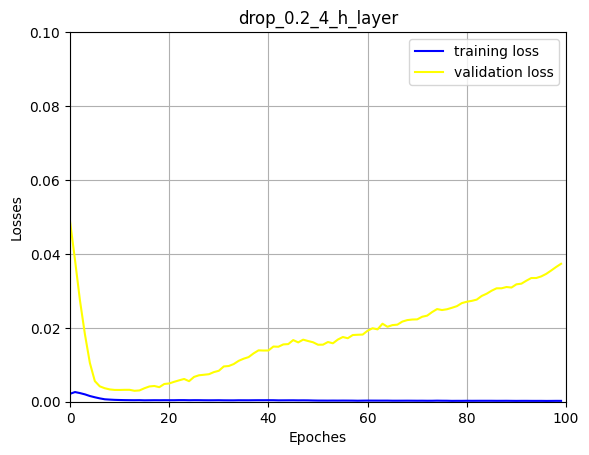

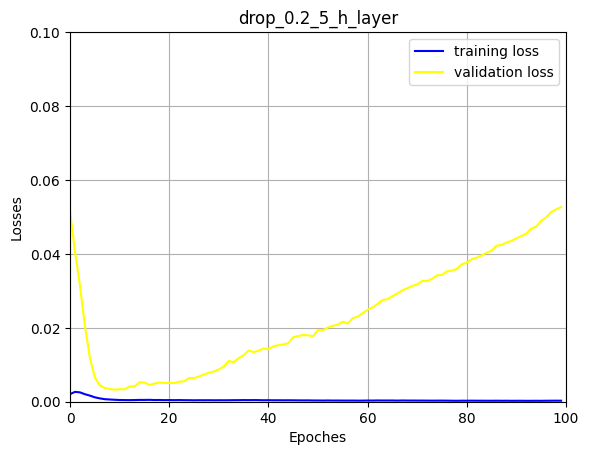

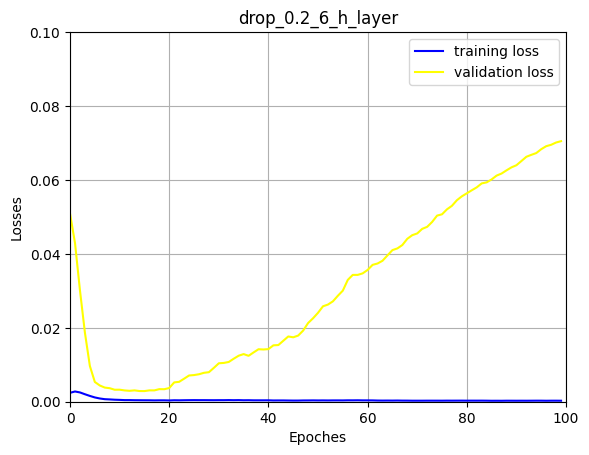

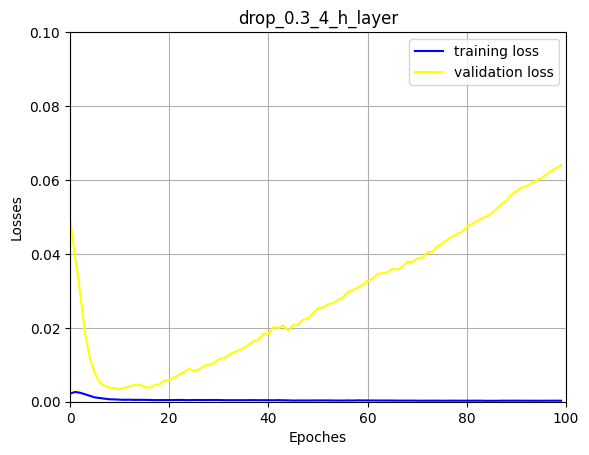

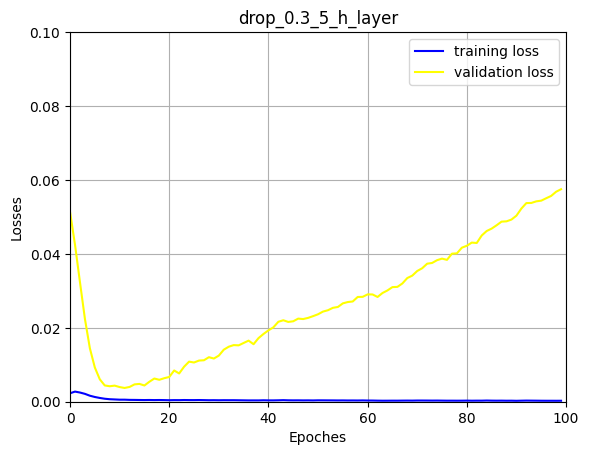

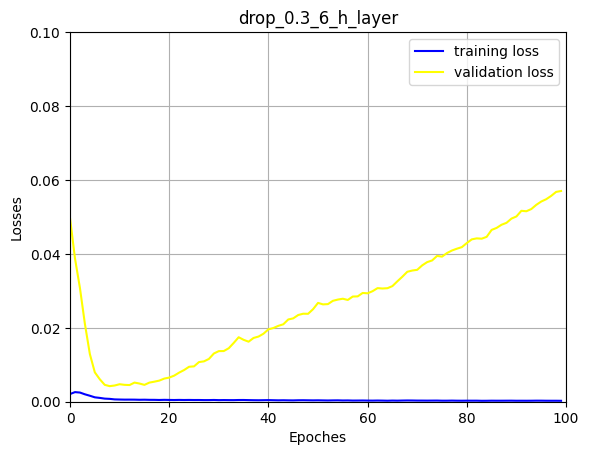

In [ ]:
for name, history in histories.items():
  plt.title(name)
  plot_loss(history.history['loss'],history.history['val_loss'], "Loss")

In [43]:
#prediction
Y_prediction = model.predict(X_test)
Y_prediction = scaler.inverse_transform(Y_prediction)

8/8 [==============================] - 1s 4ms/step


In [44]:
Y_prediction.shape

(242, 1)

In [45]:
train_df = data.iloc[:training_size , :]
train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
test_df = data.iloc[training_size: , :]
test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


<ipython-input-45-4ef475970526>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.Date = pd.to_datetime(train_df.Date, format = '%Y/%m/%d')
<ipython-input-45-4ef475970526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.Date = pd.to_datetime(test_df.Date, format = '%Y/%m/%d')


In [46]:
test_df.shape

(252, 2)

In [47]:
test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values

test_df.iloc[lag:, 2] = Y_prediction

<ipython-input-47-e78d812fd9ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Prediction'] = np.nan # Initialize new column 'Prediction' with NaN values


In [48]:
test_df.head(12)

,Date,Close,Prediction
1007,2019-07-11,47.720001,NaN
1008,2019-07-12,49.015999,NaN
1009,2019-07-15,50.700001,NaN
1010,2019-07-16,50.476002,NaN
1011,2019-07-17,50.972000,NaN
1012,2019-07-18,50.708000,NaN
1013,2019-07-19,51.636002,NaN
1014,2019-07-22,51.136002,NaN
1015,2019-07-23,52.034000,NaN
1016,2019-07-24,52.976002,NaN


<Axes: xlabel='Date'>

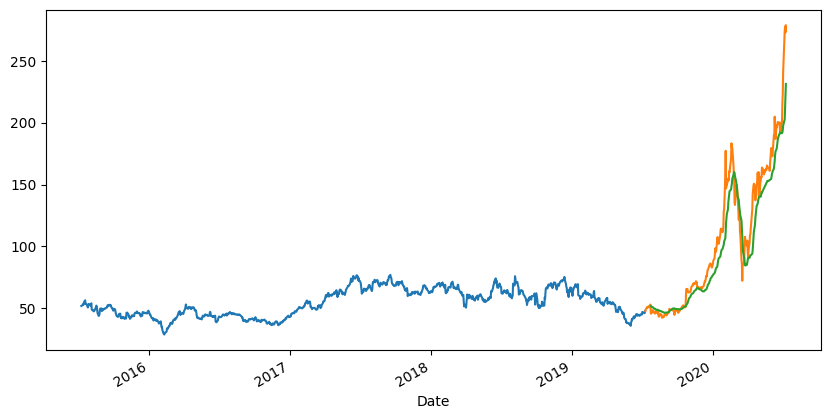

In [49]:
plot = train_df.set_index('Date')
plot2 = test_df.set_index('Date')


plot['Close'].plot(figsize=(10,5))
plot2['Close'].plot(figsize=(10,5))
plot2['Prediction'].plot(figsize=(10,5))